In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Antes de empezar, nos aseguramos de usar GPU

In [2]:
!nvidia-smi

Mon Jul 15 03:25:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Se define el estacionamiento prohibido

In [3]:
SOURCE_VIDEO_PATH = '/content/drive/MyDrive/Taller_tio_Agusto/Video_auto_estacionado.mp4'

In [4]:
# Se define la zona a utilizar como estacionamiento restringido
x1 = 490
y1 = 300
x2 = 660
y2 = 380

ZONE = (x1,y1,x2,y2) # Coordenadas de la zona de interés [(x1, y1), (x2, y2)]

Tiempo_estacionado = 40  # Tiempo en segundos


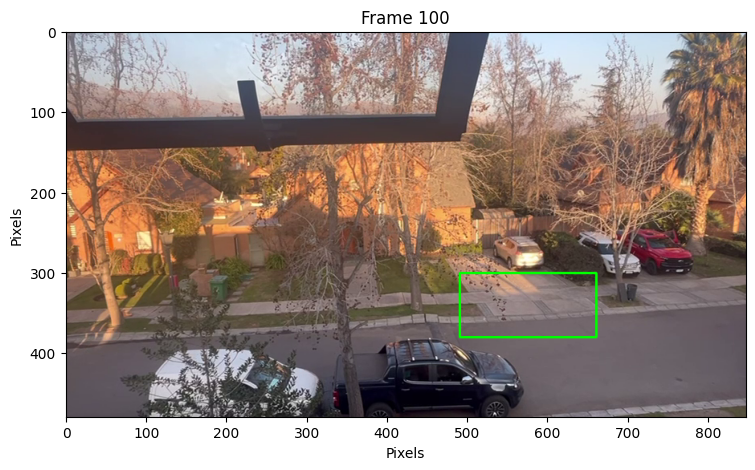

In [5]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Cargar el video
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)


frame_number = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

# Verificar si el frame fue leído correctamente
if not ret:
    print("No se pudo leer el frame.")
    cap.release()
    exit()

# Convertir el frame de BGR (formato de OpenCV) a RGB (formato de matplotlib)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

cv2.rectangle(frame_rgb, (ZONE[0], ZONE[1]), (ZONE[2], ZONE[3]), (0, 255, 0), 2)

# Mostrar el frame utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(frame_rgb)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title(f'Frame {frame_number}')
plt.show()

cap.release()


## Se importan librerias

In [6]:
from ultralytics import YOLO

In [7]:
import os
HOME = os.getcwd()
# print(HOME)

In [8]:
!pip install supervision==0.1.0

from IPython import display
display.clear_output()

import supervision


In [9]:
import supervision as sv
import numpy as np
import torch
from collections import defaultdict
import time

In [10]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [11]:
from datetime import datetime

## Detección de auto en zona prohibida

In [12]:
model = YOLO("yolov8n.pt")
model.fuse()

YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


In [13]:
CLASS_NAMES_DICT = {2: "auto", 3:'moto', 5: 'bus', 7: 'camion'} # car, motorcycle, bus and truck
CLASS_NAMES_DICT2 = model.model.names


def get_video_duration(path):
    cap = cv2.VideoCapture(path)
    if cap.isOpened():
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        duration = frame_count / fps
    else:
        duration = 0
    cap.release()
    return duration

# Función para obtener los frames del video
def get_video_frames_with_time(path):
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            time_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
            if frame_count % int(fps) == 0:  # Procesar un frame por segundo
                yield frame, time_msec
            frame_count += 1
        else:
            break
    cap.release()

# Función para mostrar frames en el notebook
def show_frame_in_notebook(frame, figsize):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Función para verificar si una detección está en la zona de interés
def isin_zone(box, zone):
    x1, y1, x2, y2 = box # izq arriba, der abajo
    zx1, zy1, zx2, zy2 = zone
    ux = np.abs(zx1-zx2) * 0.1
    uy = np.abs(zy1-zy2) * 0.1
    return (zx1 + ux <= x1 <= zx2 - ux and zy1 + uy <= y1 <= zy2 - uy) or (zx1 +ux <= x2 <= zx2 - ux and zy1 + uy <= y2 <= zy2 - uy) or (zx1 + ux <= x2 <= zx2 - ux and zy1 + uy <= y1 <= zy2 - uy) or (zx1 + ux <= x1 <= zx2 - ux and zy1 + uy <= y2 <= zy2 - uy)


In [14]:
# Inicializar generador de frames y anotador de cajas
generator = get_video_frames_with_time(SOURCE_VIDEO_PATH)

print(generator)
autos_malos = np.zeros(int(get_video_duration(SOURCE_VIDEO_PATH))+3)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=1, text_scale=0.5)
contador = 0


# Procesar y anotar frames
for frame, time_msec in generator:
    # Obtener resultados del modelo
    results = model(frame)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # Formatear etiquetas personalizadas
    labels = [
        f"{CLASS_NAMES_DICT2[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id
        in detections
    ]

    # Verificar si alguna detección está en la zona de interés
    for i, (box, class_id) in enumerate(zip(detections.xyxy, detections.class_id)):
        if class_id == 2:  # Solo considerar autos
            if isin_zone(box, ZONE):
                autos_malos[contador] = 1
                print(f"Hay auto en la zona a los {time_msec / 1000:.2f} segundos")
    contador += 1

    # Anotar frame y dibujar la zona de interés
    frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
    cv2.rectangle(frame, (ZONE[0], ZONE[1]), (ZONE[2], ZONE[3]), (0, 255, 0), 2)

    # Obtener la hora actual
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (250, 250, 250)  # Blanco
    lineType = 3

    # Calcular el tamaño del texto para centrarlo
    textSize = cv2.getTextSize(current_time, font, fontScale, lineType)[0]
    textX = (frame.shape[1] - textSize[0]) // 2
    textY = frame.shape[0] - 10

    cv2.putText(frame, current_time,
                (textX, textY),
                font,
                fontScale,
                fontColor,
                lineType)

    # Guardar frame anotado como imagen
    image_path = os.path.join('/content/drive/MyDrive/Taller_tio_Agusto/output', f'frame_{contador:05d}.png')
    cv2.imwrite(image_path, frame)

# Obtener y mostrar la duración del video
video_duration = get_video_duration(SOURCE_VIDEO_PATH)
print(f"Duración del video: {video_duration:.2f} segundos")




<generator object get_video_frames_with_time at 0x7be46e648ba0>

0: 384x640 6 cars, 1 truck, 1 parking meter, 308.6ms
Speed: 4.4ms preprocess, 308.6ms inference, 1660.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 12.3ms
Speed: 7.0ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 15.8ms
Speed: 2.6ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 16.1ms
Speed: 5.6ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 14.7ms
Speed: 2.6ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape

In [15]:
def find_consecutive_ones_indices(arr):
    # Lista para almacenar los pares de índices
    result = []
    # Variables para rastrear la secuencia
    count = 0
    start_index = None

    # Iterar sobre la lista
    for i, num in enumerate(arr):
        if num == 1:
            if count == 0:
                start_index = i
            count += 1
        else:
            if count >= Tiempo_estacionado:
                result.append((start_index, i - 1))
            count = 0

    # Verificar si la secuencia final no fue procesada
    if count >= Tiempo_estacionado:
        result.append((start_index, len(arr) - 1))

    return result

In [16]:
print(autos_malos)

[          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           1           1           1           1           1           1           1           1           1
           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
           1           1           1           1           1 

In [17]:
find_consecutive_ones_indices(autos_malos)

[(17, 84)]

In [18]:
output_folder = '/content/drive/MyDrive/Taller_tio_Agusto/output'
images = [img for img in sorted(os.listdir(output_folder)) if img.endswith(".png")]
for dupla in find_consecutive_ones_indices(autos_malos):
    Inicio = dupla[0]
    Fin = dupla[1]
    for i in range(Inicio +1, Fin + 2):
        image_path = os.path.join(output_folder, f'frame_{i:05d}.png')

        # Leer la imagen
        frame = cv2.imread(image_path)

        # Verificar que la imagen fue leída correctamente
        if frame is not None:
            # Definir el texto y las propiedades del texto
            text = "Hay un auto mal estacionado"
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            fontColor = (0, 0, 255)  # Rojo
            lineType = 2

            # Calcular el tamaño del texto para centrarlo
            textSize = cv2.getTextSize(text, font, fontScale, lineType)[0]
            textX = (frame.shape[1] - textSize[0]) // 2
            textY = frame.shape[0] - 50  # Un poco más arriba de la parte inferior

            # Poner el texto en el frame
            cv2.putText(frame, text,
                        (textX, textY),
                        font,
                        fontScale,
                        fontColor,
                        lineType)

            # Guardar la imagen de nuevo con el texto añadido
            cv2.imwrite(image_path, frame)
        else:
            print(f"Error al leer la imagen: {image_path}")

In [19]:
video_name = os.path.join('/content/drive/MyDrive/Taller_tio_Agusto/output', 'video_output.mp4')
output_folder = '/content/drive/MyDrive/Taller_tio_Agusto/output'
images = [img for img in sorted(os.listdir(output_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(output_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(output_folder, image)))

cv2.destroyAllWindows()
video.release()